<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 323, '日付': '2021-03-18T08:00:00.000Z'},
 {'小計': 303, '日付': '2021-03-19T08:00:00.000Z'},
 {'小計': 342, '日付': '2021-03-20T08:00:00.000Z'},
 {'小計': 256, '日付': '2021-03-21T08:00:00.000Z'},
 {'小計': 187, '日付': '2021-03-22T08:00:00.000Z'},
 {'小計': 337, '日付': '2021-03-23T08:00:00.000Z'},
 {'小計': 420, '日付': '2021-03-24T08:00:00.000Z'},
 {'小計': 394, '日付': '2021-03-25T08:00:00.000Z'},
 {'小計': 376, '日付': '2021-03-26T08:00:00.000Z'},
 {'小計': 430, '日付': '2021-03-27T08:00:00.000Z'},
 {'小計': 313, '日付': '2021-03-28T08:00:00.000Z'},
 {'小計': 234, '日付': '2021-03-29T08:00:00.000Z'},
 {'小計': 364, '日付': '2021-03-30T08:00:00.000Z'},
 {'小計': 414, '日付': '2021-03-31T08:00:00.000Z'},
 {'小計': 475, '日付': '2021-04-01T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-03-28 17:00:00+09:00,269,0,313,2021-03-28 17:00:00+09:00
2021-03-29 17:00:00+09:00,309,0,234,2021-03-29 17:00:00+09:00
2021-03-30 17:00:00+09:00,279,0,364,2021-03-30 17:00:00+09:00
2021-03-31 17:00:00+09:00,326,0,414,2021-03-31 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-03-28 17:00:00+09:00,269,0,313,2021-03-28 17:00:00+09:00,269.857143,1889.0,0.0,0.0,351.000000,2457.0
2021-03-29 17:00:00+09:00,309,0,234,2021-03-29 17:00:00+09:00,273.000000,1911.0,0.0,0.0,357.714286,2504.0
2021-03-30 17:00:00+09:00,279,0,364,2021-03-30 17:00:00+09:00,277.000000,1939.0,0.0,0.0,361.571429,2531.0
2021-03-31 17:00:00+09:00,326,0,414,2021-03-31 17:00:00+09:00,286.857143,2008.0,0.0,0.0,360.714286,2525.0
2021-04-01 17:00:00+09:00,0,0,475,2021-04-01 17:00:00+09:00,250.000000,1750.0,0.0,0.0,372.285714,2606.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-03-18 17:00:00+09:00,264,0,323,2021-03-18 17:00:00+09:00,239.857143,1679.0,0.0,0.0,297.142857,2080.0,'21w11,Thu
2021-03-19 17:00:00+09:00,265,0,303,2021-03-19 17:00:00+09:00,247.714286,1734.0,0.0,0.0,297.000000,2079.0,'21w11,Fri
2021-03-20 17:00:00+09:00,292,0,342,2021-03-20 17:00:00+09:00,255.857143,1791.0,0.0,0.0,298.714286,2091.0,'21w11,Sat
2021-03-21 17:00:00+09:00,264,0,256,2021-03-21 17:00:00+09:00,261.571429,1831.0,0.0,0.0,301.142857,2108.0,'21w11,Sun
2021-03-22 17:00:00+09:00,287,0,187,2021-03-22 17:00:00+09:00,264.142857,1849.0,0.0,0.0,302.857143,2120.0,'21w12,Mon
2021-03-23 17:00:00+09:00,251,0,337,2021-03-23 17:00:00+09:00,267.428571,1872.0,0.0,0.0,308.142857,2157.0,'21w12,Tue
2021-03-24 17:00:00+09:00,257,0,420,2021-03-24 17:00:00+09:00,268.571429,1880.0,0.0,0.0,309.714286,2168.0,'21w12,Wed
2021-03-25 17:00:00+09:00,258,0,394,2021-03-25 17:00:00+09:00,267.714286,1874.0,0.0,0.0,319.857143,2239.0,'21w12,Thu
2021-03-26 17:00:00+09:00,259,0,376,2021-03-26 17:00:00+09:00,266.857143,1868.0,0.0,0.0,330.285714,2312.0,'21w12,Fri
2021-03-27 17:00:00+09:00,308,0,430,2021-03-27 17:00:00+09:00,269.142857,1884.0,0.0,0.0,342.857143,2400.0,'21w12,Sat


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-03-14 17:00:00+09:00,279.142857,1954
2021-03-21 17:00:00+09:00,301.142857,2108
2021-03-28 17:00:00+09:00,351.000000,2457
2021-04-01 17:00:00+09:00,371.750000,1487
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-03-18 17:00:00+09:00,264,0,323,2021-03-18 17:00:00+09:00,239.857143,1679.0,0.0,0.0,297.142857,2080.0,'21w11,Thu,NaN,NaN
2021-03-19 17:00:00+09:00,265,0,303,2021-03-19 17:00:00+09:00,247.714286,1734.0,0.0,0.0,297.000000,2079.0,'21w11,Fri,NaN,NaN
2021-03-20 17:00:00+09:00,292,0,342,2021-03-20 17:00:00+09:00,255.857143,1791.0,0.0,0.0,298.714286,2091.0,'21w11,Sat,NaN,NaN
2021-03-21 17:00:00+09:00,264,0,256,2021-03-21 17:00:00+09:00,261.571429,1831.0,0.0,0.0,301.142857,2108.0,'21w11,Sun,301.142857,2108.0
2021-03-22 17:00:00+09:00,287,0,187,2021-03-22 17:00:00+09:00,264.142857,1849.0,0.0,0.0,302.857143,2120.0,'21w12,Mon,NaN,NaN
2021-03-23 17:00:00+09:00,251,0,337,2021-03-23 17:00:00+09:00,267.428571,1872.0,0.0,0.0,308.142857,2157.0,'21w12,Tue,NaN,NaN
2021-03-24 17:00:00+09:00,257,0,420,2021-03-24 17:00:00+09:00,268.571429,1880.0,0.0,0.0,309.714286,2168.0,'21w12,Wed,NaN,NaN
2021-03-25 17:00:00+09:00,258,0,394,2021-03-25 17:00:00+09:00,267.714286,1874.0,0.0,0.0,319.857143,2239.0,'21w12,Thu,NaN,NaN
2021-03-26 17:00:00+09:00,259,0,376,2021-03-26 17:00:00+09:00,266.857143,1868.0,0.0,0.0,330.285714,2312.0,'21w12,Fri,NaN,NaN
2021-03-27 17:00:00+09:00,308,0,430,2021-03-27 17:00:00+09:00,269.142857,1884.0,0.0,0.0,342.857143,2400.0,'21w12,Sat,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

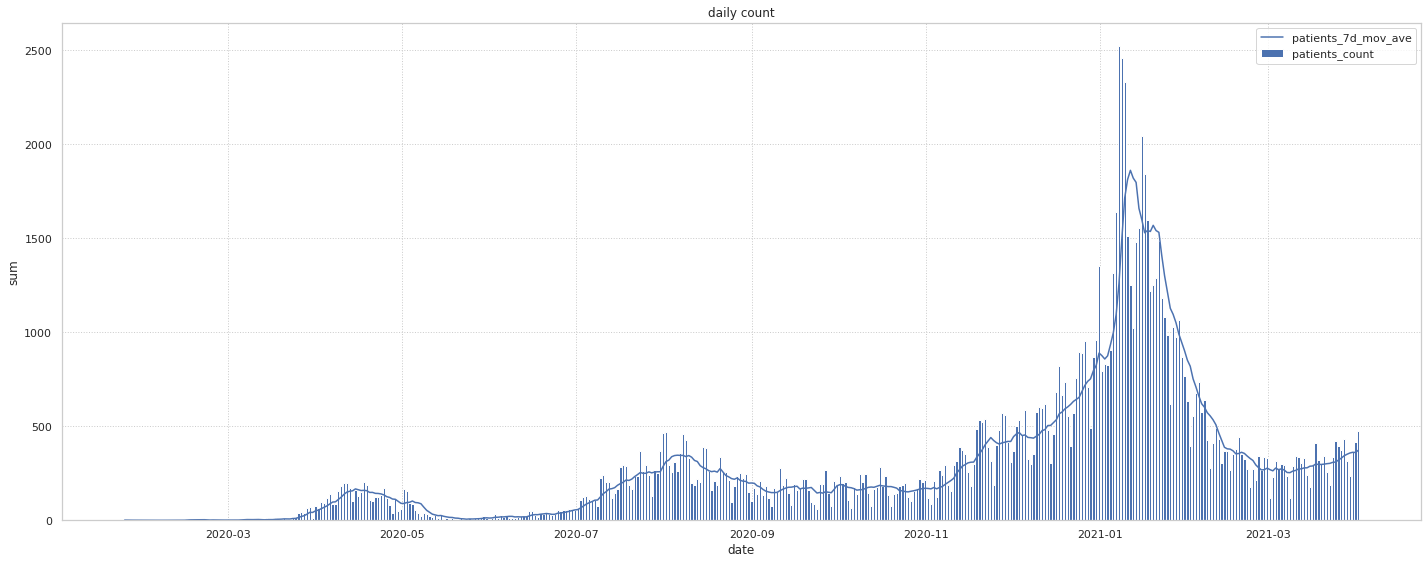

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
419,1.616054e+09,2021,3,18,0,0,0,0,1,0,0,419,0,345,264,239.857143,1679.0,0,0.0,0.0,323,297.142857,2080.0
420,1.616141e+09,2021,3,19,1,0,0,0,0,0,0,420,0,346,265,247.714286,1734.0,0,0.0,0.0,303,297.000000,2079.0
421,1.616227e+09,2021,3,20,0,0,1,0,0,0,0,421,0,347,292,255.857143,1791.0,0,0.0,0.0,342,298.714286,2091.0
422,1.616314e+09,2021,3,21,0,0,0,1,0,0,0,422,0,348,264,261.571429,1831.0,0,0.0,0.0,256,301.142857,2108.0
423,1.616400e+09,2021,3,22,0,1,0,0,0,0,0,423,0,349,287,264.142857,1849.0,0,0.0,0.0,187,302.857143,2120.0
424,1.616486e+09,2021,3,23,0,0,0,0,0,1,0,424,0,350,251,267.428571,1872.0,0,0.0,0.0,337,308.142857,2157.0
425,1.616573e+09,2021,3,24,0,0,0,0,0,0,1,425,0,351,257,268.571429,1880.0,0,0.0,0.0,420,309.714286,2168.0
426,1.616659e+09,2021,3,25,0,0,0,0,1,0,0,426,0,352,258,267.714286,1874.0,0,0.0,0.0,394,319.857143,2239.0
427,1.616746e+09,2021,3,26,1,0,0,0,0,0,0,427,0,353,259,266.857143,1868.0,0,0.0,0.0,376,330.285714,2312.0
428,1.616832e+09,2021,3,27,0,0,1,0,0,0,0,428,0,354,308,269.142857,1884.0,0,0.0,0.0,430,342.857143,2400.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            434 non-null    float64
 1   year                 434 non-null    int64  
 2   month                434 non-null    int64  
 3   day                  434 non-null    int64  
 4   Fri                  434 non-null    uint8  
 5   Mon                  434 non-null    uint8  
 6   Sat                  434 non-null    uint8  
 7   Sun                  434 non-null    uint8  
 8   Thu                  434 non-null    uint8  
 9   Tue                  434 non-null    uint8  
 10  Wed                  434 non-null    uint8  
 11  passed               434 non-null    int64  
 12  emergency            434 non-null    int64  
 13  em_passed            434 non-null    int64  
 14  contacts_count       434 non-null    int64  
 15  contacts_7d_mov_ave  434 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,4.340000e+02,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000
mean,1.598558e+09,2020.209677,5.864055,15.875576,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,216.500000,0.112903,148.894009,692.619816,691.133586,4837.926267,849.122120,849.122120,5943.854839,279.864055,277.192001,1940.306452
std,1.083709e+07,0.407548,3.524569,8.877831,0.350331,0.350331,0.350331,0.350331,0.350331,0.350331,0.350331,125.429263,0.316840,116.390371,460.349572,447.043421,3129.317561,881.771454,778.782072,5451.474506,367.973242,348.753824,2441.306629
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.589206e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,108.250000,0.000000,34.250000,384.000000,388.464286,2719.250000,0.000000,0.000000,0.000000,40.250000,36.535714,255.750000
50%,1.598558e+09,2020.000000,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,216.500000,0.000000,142.500000,557.000000,575.142857,4026.000000,741.000000,961.642857,6731.500000,184.000000,174.785714,1223.500000
75%,1.607911e+09,2020.000000,9.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,324.750000,0.000000,250.750000,835.000000,870.000000,6090.000000,1459.500000,1426.285714,9984.000000,338.500000,335.250000,2346.750000
max,1.617264e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,433.000000,1.000000,359.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,7.050823e-01,0.187206,0.020665,-9.775696e-03,-1.133055e-17,-6.517130e-03,-3.258565e-03,9.775696e-03,3.258565e-03,6.517130e-03,1.000000e+00,-3.374334e-01,0.993300,-0.257438,-0.233782,-0.233776,-0.440969,-4.731462e-01,-4.731462e-01,0.586969,0.625075,0.625094
year,7.050823e-01,1.000000e+00,-0.562127,-0.029156,2.244786e-18,2.379473e-17,4.534467e-17,2.379473e-17,1.795829e-18,2.379473e-17,2.469264e-18,7.050823e-01,-1.837559e-01,0.731510,-0.239686,-0.207404,-0.207401,-0.496579,-5.622491e-01,-5.622491e-01,0.549488,0.611826,0.611827
month,1.872064e-01,-5.621273e-01,1.000000,-0.017960,-1.229101e-02,8.015873e-04,-8.550265e-03,-4.809524e-03,1.202381e-02,4.542328e-03,8.283069e-03,1.872064e-01,-1.371935e-01,0.142279,0.034836,0.017792,0.017796,0.175863,2.310827e-01,2.310827e-01,-0.078128,-0.121244,-0.121221
day,2.066522e-02,-2.915599e-02,-0.017960,1.000000,1.018357e-02,-9.122778e-03,1.018357e-02,1.166867e-02,-6.895123e-03,-8.380226e-03,-7.637675e-03,2.066522e-02,-7.309926e-03,0.023368,-0.021556,-0.023236,-0.023240,-0.004617,-2.329464e-02,-2.329464e-02,-0.005205,0.005622,0.005605
Fri,-9.775696e-03,2.244786e-18,-0.012291,0.010184,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-9.775696e-03,1.645846e-17,-0.008690,-0.017663,-0.001782,-0.001781,0.040793,4.089938e-18,1.539742e-17,0.047214,-0.002874,-0.002884
Mon,-1.133055e-17,2.379473e-17,0.000802,-0.009123,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,5.788375e-18,1.819093e-17,-0.000024,0.041379,0.000084,0.000085,0.161294,1.178865e-17,1.649723e-17,-0.111890,-0.000248,-0.000246
Sat,-6.517130e-03,4.534467e-17,-0.008550,0.010184,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-6.517130e-03,1.703595e-17,-0.005801,0.047895,-0.001133,-0.001132,-0.186183,2.429905e-17,2.089649e-17,0.053735,-0.001716,-0.001723
Sun,-3.258565e-03,2.379473e-17,-0.004810,0.011669,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-3.258565e-03,1.761344e-17,-0.002913,-0.015329,-0.000567,-0.000565,-0.171537,6.495785e-18,2.199631e-17,-0.035177,-0.000877,-0.000878
Thu,9.775696e-03,1.795829e-18,0.012024,-0.006895,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,9.775696e-03,1.703595e-17,0.008755,-0.015257,0.001359,0.001360,0.047058,0.000000e+00,2.089649e-17,0.077795,0.003131,0.003138
Tue,3.258565e-03,2.379473e-17,0.004542,-0.008380,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,3.258565e-03,1.703595e-17,0.002864,-0.025138,0.000672,0.000673,0.064350,5.533446e-18,2.309612e-17,-0.036682,0.000733,0.000737


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,1.616918e+09,0,0,0,1,0,0,0,429,0,355,269,0,313,351.000000,2457.0
430,1.617005e+09,0,1,0,0,0,0,0,430,0,356,309,0,234,357.714286,2504.0
431,1.617091e+09,0,0,0,0,0,1,0,431,0,357,279,0,364,361.571429,2531.0
432,1.617178e+09,0,0,0,0,0,0,1,432,0,358,326,0,414,360.714286,2525.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
429,1.616918e+09,429,0,313,351.000000,2457.0
430,1.617005e+09,430,0,234,357.714286,2504.0
431,1.617091e+09,431,0,364,361.571429,2531.0
432,1.617178e+09,432,0,414,360.714286,2525.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

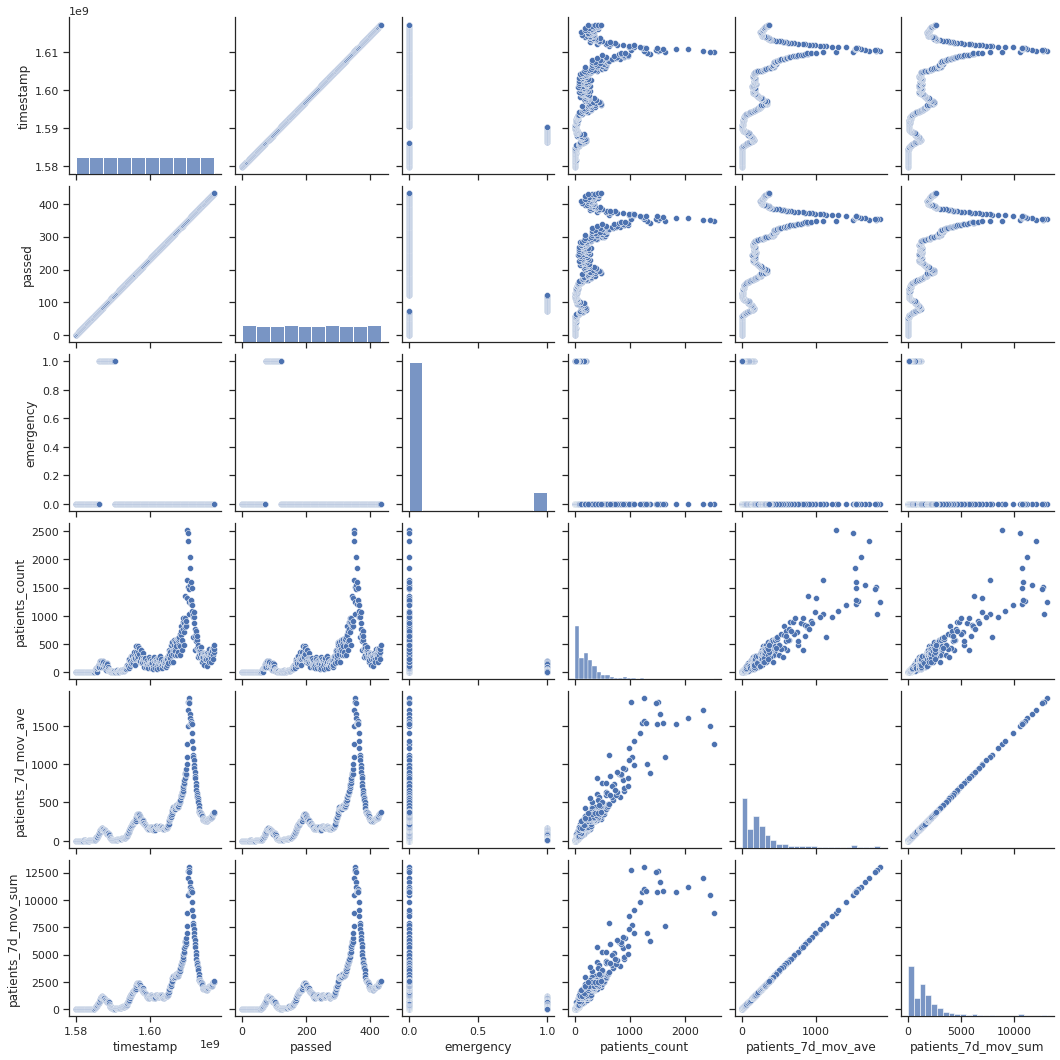

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
